In [67]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import requests

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

In [70]:
df_transactions = pd.read_csv('transactions.csv')
df_transactions['dates'] = pd.to_datetime(df_transactions['dates'])
df_transactions.tail()

,dates,SKU,user,price
1334255,2019-04-21,16663,20223,2240.0
1334256,2019-04-21,16663,25555,2240.0
1334257,2019-04-21,16663,47340,2240.0
1334258,2019-04-21,16663,23762,2240.0
1334259,2019-04-21,16663,48007,2240.0


In [71]:
df_wholesale_trade_table = pd.read_csv('wholesale_trade_table.csv')
df_wholesale_trade_table = df_wholesale_trade_table.sort_values(by=['year', 'month', 'week_num'])
df_wholesale_trade_table.tail()

,SKU,year,week_num,month,cost_price
60898,98842,2019,52,12,1206.0
60976,99266,2019,52,12,1632.0
61079,99310,2019,52,12,355.0
61181,99974,2019,52,12,2900.0
61251,99996,2019,52,12,692.0


# Data preparation

In [73]:
def date_to_datetime(df):
    df['quarter_of_year'] = df.dates.dt.quarter
    df['day_of_year'] = df.dates.dt.dayofyear
    df['day_of_month'] = df.dates.dt.day
    df['day_of_week'] = df.dates.dt.dayofweek
    df["is_wknd"] = df.dates.dt.weekday // 4
    df['is_month_start'] = df.dates.dt.is_month_start.astype(int)
    df['is_month_end'] = df.dates.dt.is_month_end.astype(int)
    df = df.drop(columns=['dates'])
    
    return df

In [74]:
df_transactions = pd.read_csv('transactions.csv')
df_transactions['dates'] = pd.to_datetime(df_transactions['dates'])
df_transactions['year'] = df_transactions.dates.dt.year
df_transactions['month'] = df_transactions.dates.dt.month
df_transactions['week_num'] = df_transactions.dates.dt.isocalendar().week.astype(int)
df_transactions = df_transactions.sort_values(by=['year', 'month', 'week_num'])

df_wholesale_trade_table = df_wholesale_trade_table.sort_values(by=['year', 'month', 'week_num'])

df_price_cost = pd.merge(df_transactions, df_wholesale_trade_table,
                         how='left', on=['SKU', 'year',
                                         'month', 'week_num'])

df_price_cost = date_to_datetime(df_price_cost)
df_price_cost = df_price_cost.rename(columns={"user": "user_id"})
df_price_cost

,SKU,user_id,price,year,month,week_num,cost_price,quarter_of_year,day_of_year,day_of_month,day_of_week,is_wknd
0,50389,11733,2432.0,2018,1,1,2097.0,1,4,4,3,0
1,50389,23396,2432.0,2018,1,1,2097.0,1,4,4,3,0
2,50389,18823,2432.0,2018,1,1,2097.0,1,4,4,3,0
3,50389,24631,2432.0,2018,1,1,2097.0,1,4,4,3,0
4,50389,26332,2432.0,2018,1,1,2097.0,1,4,4,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1334255,91775,14921,1355.0,2019,11,48,1189.0,4,333,29,4,1
1334256,91775,34110,1355.0,2019,11,48,1189.0,4,333,29,4,1
1334257,91775,28960,1355.0,2019,11,48,1189.0,4,334,30,5,1
1334258,91775,12046,1355.0,2019,11,48,1189.0,4,334,30,5,1


In [75]:
params = {
    'n_estimators': 1500,
    'max_depth': 6,
    'learning_rate': 0.01
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

Y_train = df_price_cost['price']
X_train = df_price_cost.drop(columns=['price'])


model.fit(X_train, Y_train,
          verbose = 0)

LGBMRegressor(first_metric_only=True, learning_rate=0.01, max_depth=6,
              n_estimators=5000)

In [76]:
features=pd.get_dummies(X_train,drop_first=True)

feature_importances = pd.DataFrame(
    {'features': features.columns, 'feature_importance': model.feature_importances_})
feature_importances.sort_values('feature_importance', ascending=False)

,features,feature_importance
5,cost_price,66591
0,SKU,48377
4,week_num,15219
7,day_of_year,5335
8,day_of_month,5311
3,month,5279
2,year,3504
9,day_of_week,348
1,user_id,35
6,quarter_of_year,1


Plotting feature importances...


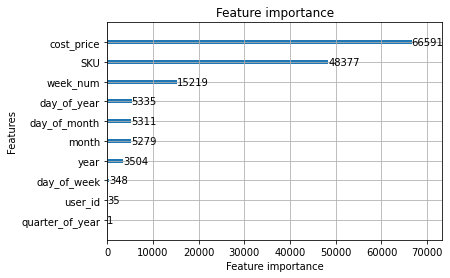

In [77]:
print('Plotting feature importances...')
ax = lgb.plot_importance(model, max_num_features=10)
plt.show()

In [78]:
UUID = '278a6454351246b696fd4a2bf5aec4d9'

URL_BEGIN_DATA = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/begin'
req = requests.post(URL_BEGIN_DATA.format(uuid=UUID))
print(req.json())

for i in range(31):
    print(f"number {i}")

    URL_TASK_DATA_GET = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/data'
    response = requests.get(URL_TASK_DATA_GET.format(uuid=UUID))
    print(response)

    df = pd.read_json(response.json())
    df_ = df.copy()
    df_['dates'] = pd.to_datetime(df_['dates'])

    df_['year'] = df_.dates.dt.year
    df_['month'] = df_.dates.dt.month
    df_['week_num'] = df_.dates.dt.isocalendar().week

    df_ = pd.merge(df_, df_wholesale_trade_table,
                   how='left', on=['SKU', 'year', 'month', 'week_num'])

    df_ = date_to_datetime(df_)
    
    params = {
        'n_estimators': 1500,
        'max_depth': 6,
        'learning_rate': 0.1
    }

    model = lgb.LGBMRegressor(first_metric_only = True, **params)

    Y_train = df_price_cost['price']
    X_train = df_price_cost.drop(columns=['price'])

    X_test = df_

    model.fit(X_train, Y_train,
              verbose = 0)

    forecast = model.predict(X_test)

    df['price'] = forecast

    URL_TASK_RESULT_POST = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/result/'
    response_receive = requests.post(URL_TASK_RESULT_POST.format(uuid=UUID),
                                     data=df[['dates', 'SKU', 'user_id', 'price']].to_json(orient='records'))

    print(response_receive.json()['status'])

#     break

{'status': 'ok'}
number 0
<Response [200]>
ok


In [23]:
print(response.json()['status'])

batch processing finished


In [57]:
URL_TASK_RESULT_GET = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/result'
response = requests.get(URL_TASK_RESULT_GET.format(uuid=UUID))

# Чтобы перевести полученный ответ в pd.DataFrame
df = pd.read_json(response.json())
df.head()

,dates,SKU,user_id,price,bought
0,2019-12-01,16019,32813,1040.411870,1
1,2019-12-01,84011,55841,4062.875107,0
2,2019-12-01,84011,16345,4062.875107,0
3,2019-12-01,29011,12544,2268.398158,0
4,2019-12-01,79558,49751,2577.125468,0


In [60]:
df_0 = df[df['bought'] == 0]
df_0.head()

,dates,SKU,user_id,price,bought
1,2019-12-01,84011,55841,4062.875107,0
2,2019-12-01,84011,16345,4062.875107,0
3,2019-12-01,29011,12544,2268.398158,0
4,2019-12-01,79558,49751,2577.125468,0
5,2019-12-01,86541,30649,2712.497225,0
